# Resnet-18 model

In [12]:
from keras.models import Model
from keras.layers import Input, GlobalAveragePooling2D, Dense, Activation

def ResNet18(show_layers=False, **kwargs):
    '''
    # classification_models 패키지 설치
    
    pip install git+https://github.com/qubvel/classification_models.git
    
    '''
    from classification_models.keras import Classifiers

    ResNet18, preprocess_input = Classifiers.get('resnet18')
    
    base_model = ResNet18(**kwargs)
    x = GlobalAveragePooling2D()(base_model.output)
    pred = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=base_model.input, outputs=pred)
    model.compile(optimizer=SGD(lr=1e-3, decay=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    if show_layers:
        for i, layer in enumerate(model.layers):
            print(i, layer.name, layer.trainable)
    
    return model

# Resnet-18 inform

In [13]:
from keras.optimizers import SGD

model = ResNet18(input_shape=(224, 224, 3), weights=None, include_top=False)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 224, 224, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_37 (ZeroPadding2 (None, 230, 230, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 112, 112, 64) 9408        zero_padding2d_37[0][0]          
__________________________________________________________________________________________________
bn0 (Batch

# CASIA-FASD

>>  Result
=============================================ResNet-18==============================================
Found 27901 images belonging to 2 classes.
Epoch 1/29
1744/1744 [==============================] - 125s 72ms/step - loss: 0.3117 - acc: 0.8808

Epoch 00001: loss improved from inf to 0.31168, saving model to trained_model_Result\CASIA-FASD\001\Result-01-0.3117.hdf5
Epoch 2/29
1744/1744 [==============================] - 123s 70ms/step - loss: 0.1156 - acc: 0.9649

Epoch 00002: loss improved from 0.31168 to 0.11559, saving model to trained_model_Result\CASIA-FASD\001\Result-02-0.1156.hdf5
Epoch 3/29
1744/1744 [==============================] - 123s 71ms/step - loss: 0.0542 - acc: 0.9884

Epoch 00003: loss improved from 0.11559 to 0.05422, saving model to trained_model_Result\CASIA-FASD\001\Result-03-0.0542.hdf5
Epoch 4/29
1744/1744 [==============================] - 123s 71ms/step - loss: 0.0358 - acc: 0.9921

Epoch 00004: loss improved from 0.05422 to 0.03579, saving model to

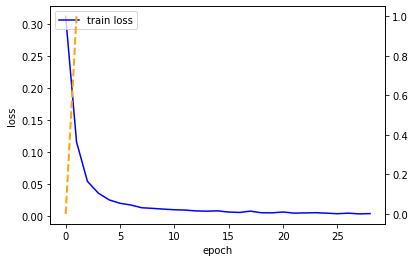

acc: 0.9991	loss: 0.0051
==========================================Result finished===========================================


In [14]:
import glob
import os
import numpy as np
import cv2
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from sklearn.metrics import roc_curve, confusion_matrix
from sklearn.utils import class_weight

%matplotlib inline
SEED = 777

def main():
    inputSize = 224
    batchSize = 16
    
    nEpoch = 29
    
    # 디렉토리 정보 설정
    # dataDir = 'D:\\Face_Database\\B-Database'
    dataDir = 'C:\\Users\\prlab\\Desktop\\bjy\\crop_result\\CASIA-FASD\\train'   
    # 학습 및 테스트 할 데이터베이스 디렉토리명
    trainDB = 'Result'  # D:\Face_Database\B-Database\protocol_4\train
    
    saveDir = 'trained_model_Result\\CASIA-FASD\\001'
    if not os.path.exists(saveDir):    
        os.makedirs(saveDir)
    model_path = os.path.join(saveDir, trainDB + '-{epoch:02d}-{loss:.4f}.hdf5')
    
    # 데이터베이스별 학습 수행
    print('>> ', trainDB)
    np.random.seed(SEED)

    print('ResNet-18'.center(100, '='))
    
    '''
    training
    '''
    K.clear_session()

    # 네트워크 정의
    model = ResNet18(input_shape=(inputSize, inputSize, 3), weights=None, include_top=False)

    # 데이터 generator 생성
    train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                       horizontal_flip=True,)
    train_generator = train_datagen.flow_from_directory(os.path.join(*[dataDir, trainDB, 'train']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=True,)


    # unbalanced class를 해결하기 위한 class_weight 설정
    class_weights = class_weight.compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes)

    # callback 함수 정의
    early_stop = EarlyStopping(patience=10, monitor='loss')
    cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='loss', verbose=1, save_best_only=True)

    # 모델 학습
    hist = model.fit_generator(train_generator, 
                               epochs=nEpoch,
                               steps_per_epoch=len(train_generator),
                               class_weight=class_weights,
                               verbose=1,
                               callbacks=[cb_checkpoint])

    
    # 학습 결과 그래프 그리기
    import matplotlib.pyplot as plt

    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    lw = 2
    
    plt.plot([0, 1], [0, 1], color='orange', lw=lw, linestyle='--')
    loss_ax.plot(hist.history['loss'], 'b', label='train loss')
#    loss_ax.plot(hist.history['val_loss'], '--r', label='val loss')
    
#    np.save('trained_model_Result\\CASIA-FASD\\CASIA-FASD-1', hist.history['loss'])
    
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')

    plt.show()
    print('acc: {:.4f}\tloss: {:.4f}'.format(hist.history['acc'][-11], hist.history['loss'][-11]))
    
    print(('{} finished'.format(trainDB)).center(100,'='))

        
if __name__ == '__main__':
    main()

# MSU-MFSD

>>  Result
=============================================ResNet-18==============================================
Found 33356 images belonging to 2 classes.
Epoch 1/18
2085/2085 [==============================] - 149s 72ms/step - loss: 0.2735 - acc: 0.8937

Epoch 00001: loss improved from inf to 0.27346, saving model to trained_model_Result\MSU-MFSD\001\Result-01-0.2735.hdf5
Epoch 2/18
2085/2085 [==============================] - 145s 70ms/step - loss: 0.0903 - acc: 0.9758

Epoch 00002: loss improved from 0.27346 to 0.09029, saving model to trained_model_Result\MSU-MFSD\001\Result-02-0.0903.hdf5
Epoch 3/18
2085/2085 [==============================] - 145s 69ms/step - loss: 0.0349 - acc: 0.9942

Epoch 00003: loss improved from 0.09029 to 0.03494, saving model to trained_model_Result\MSU-MFSD\001\Result-03-0.0349.hdf5
Epoch 4/18
2085/2085 [==============================] - 145s 69ms/step - loss: 0.0203 - acc: 0.9968

Epoch 00004: loss improved from 0.03494 to 0.02031, saving model to train

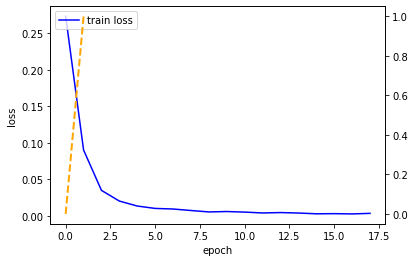

acc: 0.9989	loss: 0.0074
==========================================Result finished===========================================


In [15]:
import glob
import os
import numpy as np
import cv2
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from sklearn.metrics import roc_curve, confusion_matrix
from sklearn.utils import class_weight

%matplotlib inline
SEED = 777

def main():
    inputSize = 224
    batchSize = 16
    
    nEpoch = 18
    
    # 디렉토리 정보 설정
    # dataDir = 'D:\\Face_Database\\B-Database'
    dataDir = 'C:\\Users\\prlab\\Desktop\\bjy\\crop_result\\MSU-MFSD\\train'   
    # 학습 및 테스트 할 데이터베이스 디렉토리명
    trainDB = 'Result'  # D:\Face_Database\B-Database\protocol_4\train
    
    saveDir = 'trained_model_Result\\MSU-MFSD\\001'
    if not os.path.exists(saveDir):    
        os.makedirs(saveDir)
    model_path = os.path.join(saveDir, trainDB + '-{epoch:02d}-{loss:.4f}.hdf5')
    
    # 데이터베이스별 학습 수행
    print('>> ', trainDB)
    np.random.seed(SEED)

    print('ResNet-18'.center(100, '='))
    
    '''
    training
    '''
    K.clear_session()

    # 네트워크 정의
    model = ResNet18(input_shape=(inputSize, inputSize, 3), weights=None, include_top=False)

    # 데이터 generator 생성
    train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                       horizontal_flip=True,)
    train_generator = train_datagen.flow_from_directory(os.path.join(*[dataDir, trainDB, 'train']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=True,)


    # unbalanced class를 해결하기 위한 class_weight 설정
    class_weights = class_weight.compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes)

    # callback 함수 정의
    early_stop = EarlyStopping(patience=10, monitor='loss')
    cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='loss', verbose=1, save_best_only=True)

    # 모델 학습
    hist = model.fit_generator(train_generator, 
                               epochs=nEpoch,
                               steps_per_epoch=len(train_generator),
                               class_weight=class_weights,
                               verbose=1,
                               callbacks=[cb_checkpoint])

    
    # 학습 결과 그래프 그리기
    import matplotlib.pyplot as plt

    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    lw = 2
    
    plt.plot([0, 1], [0, 1], color='orange', lw=lw, linestyle='--')
    loss_ax.plot(hist.history['loss'], 'b', label='train loss')
#    loss_ax.plot(hist.history['val_loss'], '--r', label='val loss')
    
#    np.save('trained_model_Result\\MSU-MFSD\\MSU-MFSD-1', hist.history['loss'])
    
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')

    plt.show()
    print('acc: {:.4f}\tloss: {:.4f}'.format(hist.history['acc'][-11], hist.history['loss'][-11]))
    
    print(('{} finished'.format(trainDB)).center(100,'='))

        
if __name__ == '__main__':
    main()

# NUAA-PI

>>  Result
=============================================ResNet-18==============================================
Found 2980 images belonging to 2 classes.
Epoch 1/13
187/187 [==============================] - 15s 81ms/step - loss: 0.4543 - acc: 0.8459

Epoch 00001: loss improved from inf to 0.45504, saving model to trained_model_Result\NUAA-PI\001\13\Result-01-0.4550.hdf5
Epoch 2/13
187/187 [==============================] - 13s 70ms/step - loss: 0.1909 - acc: 0.9696

Epoch 00002: loss improved from 0.45504 to 0.19127, saving model to trained_model_Result\NUAA-PI\001\13\Result-02-0.1913.hdf5
Epoch 3/13
187/187 [==============================] - 13s 71ms/step - loss: 0.1225 - acc: 0.9713

Epoch 00003: loss improved from 0.19127 to 0.12128, saving model to trained_model_Result\NUAA-PI\001\13\Result-03-0.1213.hdf5
Epoch 4/13
187/187 [==============================] - 13s 71ms/step - loss: 0.0905 - acc: 0.9799

Epoch 00004: loss improved from 0.12128 to 0.09055, saving model to trained_mode

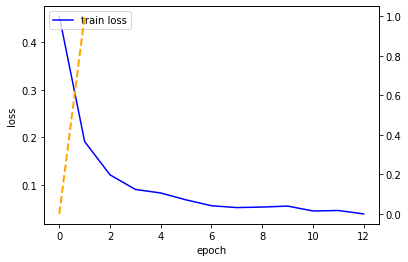

acc: 0.9721	loss: 0.1213
==========================================Result finished===========================================


In [16]:
import glob
import os
import numpy as np
import cv2
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from sklearn.metrics import roc_curve, confusion_matrix
from sklearn.utils import class_weight

%matplotlib inline
SEED = 777

def main():
    inputSize = 224
    batchSize = 16
    
    nEpoch = 13
    
    # 디렉토리 정보 설정
    # dataDir = 'D:\\Face_Database\\B-Database'
    dataDir = 'C:\\Users\\prlab\\Desktop\\bjy\\crop_result\\NUAA-PI\\train'   
    # 학습 및 테스트 할 데이터베이스 디렉토리명
    trainDB = 'Result'  # D:\Face_Database\B-Database\protocol_4\train
    
    saveDir = 'trained_model_Result\\NUAA-PI\\001\\13'
    if not os.path.exists(saveDir):    
        os.makedirs(saveDir)
    model_path = os.path.join(saveDir, trainDB + '-{epoch:02d}-{loss:.4f}.hdf5')
    
    # 데이터베이스별 학습 수행
    print('>> ', trainDB)
    np.random.seed(SEED)

    print('ResNet-18'.center(100, '='))
    
    '''
    training
    '''
    K.clear_session()

    # 네트워크 정의
    model = ResNet18(input_shape=(inputSize, inputSize, 3), weights=None, include_top=False)

    # 데이터 generator 생성
    train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                       horizontal_flip=True,)
    train_generator = train_datagen.flow_from_directory(os.path.join(*[dataDir, trainDB, 'train']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=True,)


    # unbalanced class를 해결하기 위한 class_weight 설정
    class_weights = class_weight.compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes)

    # callback 함수 정의
    early_stop = EarlyStopping(patience=10, monitor='loss')
    cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='loss', verbose=1, save_best_only=True)

    # 모델 학습
    hist = model.fit_generator(train_generator, 
                               epochs=nEpoch,
                               steps_per_epoch=len(train_generator),
                               class_weight=class_weights,
                               verbose=1,
                               callbacks=[cb_checkpoint])

    
    # 학습 결과 그래프 그리기
    import matplotlib.pyplot as plt

    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    lw = 2
    
    plt.plot([0, 1], [0, 1], color='orange', lw=lw, linestyle='--')
    loss_ax.plot(hist.history['loss'], 'b', label='train loss')
#    loss_ax.plot(hist.history['val_loss'], '--r', label='val loss')
    
#    np.save('trained_model_Result\\NUAA-PI\\NUAA-PI-1', hist.history['loss'])
    
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')

    plt.show()
    print('acc: {:.4f}\tloss: {:.4f}'.format(hist.history['acc'][-11], hist.history['loss'][-11]))
    
    print(('{} finished'.format(trainDB)).center(100,'='))

        
if __name__ == '__main__':
    main()

>>  Result
=============================================ResNet-18==============================================
Found 2980 images belonging to 2 classes.
Epoch 1/30
187/187 [==============================] - 15s 80ms/step - loss: 0.4542 - acc: 0.8459

Epoch 00001: loss improved from inf to 0.45501, saving model to trained_model_Result\NUAA-PI\001\30\Result-01-0.4550.hdf5
Epoch 2/30
187/187 [==============================] - 13s 71ms/step - loss: 0.1908 - acc: 0.9703

Epoch 00002: loss improved from 0.45501 to 0.19117, saving model to trained_model_Result\NUAA-PI\001\30\Result-02-0.1912.hdf5
Epoch 3/30
187/187 [==============================] - 13s 71ms/step - loss: 0.1223 - acc: 0.9713

Epoch 00003: loss improved from 0.19117 to 0.12114, saving model to trained_model_Result\NUAA-PI\001\30\Result-03-0.1211.hdf5
Epoch 4/30
187/187 [==============================] - 13s 71ms/step - loss: 0.0904 - acc: 0.9806

Epoch 00004: loss improved from 0.12114 to 0.09046, saving model to trained_mode

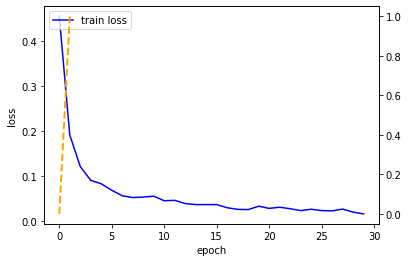

acc: 0.9926	loss: 0.0331
==========================================Result finished===========================================


In [17]:
import glob
import os
import numpy as np
import cv2
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from sklearn.metrics import roc_curve, confusion_matrix
from sklearn.utils import class_weight

%matplotlib inline
SEED = 777

def main():
    inputSize = 224
    batchSize = 16
    
    nEpoch = 30
    
    # 디렉토리 정보 설정
    # dataDir = 'D:\\Face_Database\\B-Database'
    dataDir = 'C:\\Users\\prlab\\Desktop\\bjy\\crop_result\\NUAA-PI\\train'   
    # 학습 및 테스트 할 데이터베이스 디렉토리명
    trainDB = 'Result'  # D:\Face_Database\B-Database\protocol_4\train
    
    saveDir = 'trained_model_Result\\NUAA-PI\\001\\30'
    if not os.path.exists(saveDir):    
        os.makedirs(saveDir)
    model_path = os.path.join(saveDir, trainDB + '-{epoch:02d}-{loss:.4f}.hdf5')
    
    # 데이터베이스별 학습 수행
    print('>> ', trainDB)
    np.random.seed(SEED)

    print('ResNet-18'.center(100, '='))
    
    '''
    training
    '''
    K.clear_session()

    # 네트워크 정의
    model = ResNet18(input_shape=(inputSize, inputSize, 3), weights=None, include_top=False)

    # 데이터 generator 생성
    train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                       horizontal_flip=True,)
    train_generator = train_datagen.flow_from_directory(os.path.join(*[dataDir, trainDB, 'train']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=True,)


    # unbalanced class를 해결하기 위한 class_weight 설정
    class_weights = class_weight.compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes)

    # callback 함수 정의
    early_stop = EarlyStopping(patience=10, monitor='loss')
    cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='loss', verbose=1, save_best_only=True)

    # 모델 학습
    hist = model.fit_generator(train_generator, 
                               epochs=nEpoch,
                               steps_per_epoch=len(train_generator),
                               class_weight=class_weights,
                               verbose=1,
                               callbacks=[cb_checkpoint])

    
    # 학습 결과 그래프 그리기
    import matplotlib.pyplot as plt

    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    lw = 2
    
    plt.plot([0, 1], [0, 1], color='orange', lw=lw, linestyle='--')
    loss_ax.plot(hist.history['loss'], 'b', label='train loss')
#    loss_ax.plot(hist.history['val_loss'], '--r', label='val loss')
    
#    np.save('trained_model_Result\\NUAA-PI\\NUAA-PI-1', hist.history['loss'])
    
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')

    plt.show()
    print('acc: {:.4f}\tloss: {:.4f}'.format(hist.history['acc'][-11], hist.history['loss'][-11]))
    
    print(('{} finished'.format(trainDB)).center(100,'='))

        
if __name__ == '__main__':
    main()

# Resnet-18 model

In [21]:
from keras.models import Model
from keras.layers import Input, GlobalAveragePooling2D, Dense, Activation

def ResNet18(show_layers=False, **kwargs):
    '''
    # classification_models 패키지 설치
    
    pip install git+https://github.com/qubvel/classification_models.git
    
    '''
    from classification_models.keras import Classifiers

    ResNet18, preprocess_input = Classifiers.get('resnet18')
    
    base_model = ResNet18(**kwargs)
    x = GlobalAveragePooling2D()(base_model.output)
    pred = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=base_model.input, outputs=pred)
    model.compile(optimizer=SGD(lr=1e-2, decay=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    
    if show_layers:
        for i, layer in enumerate(model.layers):
            print(i, layer.name, layer.trainable)
    
    return model

# Resnet-18 inform

In [22]:
from keras.optimizers import SGD

model = ResNet18(input_shape=(224, 224, 3), weights=None, include_top=False)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 224, 224, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_19 (ZeroPadding2 (None, 230, 230, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 112, 112, 64) 9408        zero_padding2d_19[0][0]          
__________________________________________________________________________________________________
bn0 (Batch

# CASIA-FASD

>>  Result
=============================================ResNet-18==============================================
Found 27901 images belonging to 2 classes.
Epoch 1/7
1744/1744 [==============================] - 123s 71ms/step - loss: 0.0775 - acc: 0.9741

Epoch 00001: loss improved from inf to 0.07748, saving model to trained_model_Result\CASIA-FASD\01\Result-01-0.0775.hdf5
Epoch 2/7
1744/1744 [==============================] - 121s 69ms/step - loss: 0.0105 - acc: 0.9979

Epoch 00002: loss improved from 0.07748 to 0.01046, saving model to trained_model_Result\CASIA-FASD\01\Result-02-0.0105.hdf5
Epoch 3/7
1744/1744 [==============================] - 121s 69ms/step - loss: 0.0057 - acc: 0.9989

Epoch 00003: loss improved from 0.01046 to 0.00566, saving model to trained_model_Result\CASIA-FASD\01\Result-03-0.0057.hdf5
Epoch 4/7
1744/1744 [==============================] - 123s 71ms/step - loss: 0.0043 - acc: 0.9994

Epoch 00004: loss improved from 0.00566 to 0.00427, saving model to traine

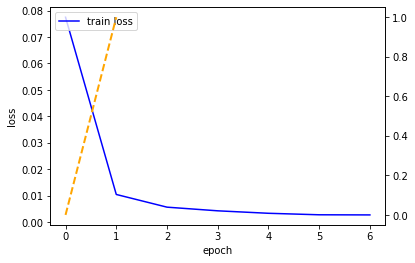

acc: 0.9995	loss: 0.0027
==========================================Result finished===========================================


In [23]:
import glob
import os
import numpy as np
import cv2
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from sklearn.metrics import roc_curve, confusion_matrix
from sklearn.utils import class_weight

%matplotlib inline
SEED = 777

def main():
    inputSize = 224
    batchSize = 16
    
    nEpoch = 7
    
    # 디렉토리 정보 설정
    # dataDir = 'D:\\Face_Database\\B-Database'
    dataDir = 'C:\\Users\\prlab\\Desktop\\bjy\\crop_result\\CASIA-FASD\\train'   
    # 학습 및 테스트 할 데이터베이스 디렉토리명
    trainDB = 'Result'  # D:\Face_Database\B-Database\protocol_4\train
    
    saveDir = 'trained_model_Result\\CASIA-FASD\\01'
    if not os.path.exists(saveDir):    
        os.makedirs(saveDir)
    model_path = os.path.join(saveDir, trainDB + '-{epoch:02d}-{loss:.4f}.hdf5')
    
    # 데이터베이스별 학습 수행
    print('>> ', trainDB)
    np.random.seed(SEED)

    print('ResNet-18'.center(100, '='))
    
    '''
    training
    '''
    K.clear_session()

    # 네트워크 정의
    model = ResNet18(input_shape=(inputSize, inputSize, 3), weights=None, include_top=False)

    # 데이터 generator 생성
    train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                       horizontal_flip=True,)
    train_generator = train_datagen.flow_from_directory(os.path.join(*[dataDir, trainDB, 'train']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=True,)


    # unbalanced class를 해결하기 위한 class_weight 설정
    class_weights = class_weight.compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes)

    # callback 함수 정의
    early_stop = EarlyStopping(patience=10, monitor='loss')
    cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='loss', verbose=1, save_best_only=True)

    # 모델 학습
    hist = model.fit_generator(train_generator, 
                               epochs=nEpoch,
                               steps_per_epoch=len(train_generator),
                               class_weight=class_weights,
                               verbose=1,
                               callbacks=[cb_checkpoint])

    
    # 학습 결과 그래프 그리기
    import matplotlib.pyplot as plt

    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    lw = 2
    
    plt.plot([0, 1], [0, 1], color='orange', lw=lw, linestyle='--')
    loss_ax.plot(hist.history['loss'], 'b', label='train loss')
#    loss_ax.plot(hist.history['val_loss'], '--r', label='val loss')
    
#    np.save('trained_model_Result\\CASIA-FASD\\CASIA-FASD-1', hist.history['loss'])
    
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')

    plt.show()
    print('acc: {:.4f}\tloss: {:.4f}'.format(hist.history['acc'][6], hist.history['loss'][6]))
    
    print(('{} finished'.format(trainDB)).center(100,'='))

        
if __name__ == '__main__':
    main()

# MSU-MFSD

>>  Result
=============================================ResNet-18==============================================
Found 33356 images belonging to 2 classes.
Epoch 1/14
2085/2085 [==============================] - 149s 71ms/step - loss: 0.0608 - acc: 0.9801

Epoch 00001: loss improved from inf to 0.06084, saving model to trained_model_Result\MSU-MFSD\01\Result-01-0.0608.hdf5
Epoch 2/14
2085/2085 [==============================] - 144s 69ms/step - loss: 0.0073 - acc: 0.99860s - loss: 0.0073 - acc: 0

Epoch 00002: loss improved from 0.06084 to 0.00732, saving model to trained_model_Result\MSU-MFSD\01\Result-02-0.0073.hdf5
Epoch 3/14
2085/2085 [==============================] - 146s 70ms/step - loss: 0.0027 - acc: 0.9998

Epoch 00003: loss improved from 0.00732 to 0.00268, saving model to trained_model_Result\MSU-MFSD\01\Result-03-0.0027.hdf5
Epoch 4/14
2085/2085 [==============================] - 148s 71ms/step - loss: 0.0018 - acc: 0.9998

Epoch 00004: loss improved from 0.00268 to 0.00183

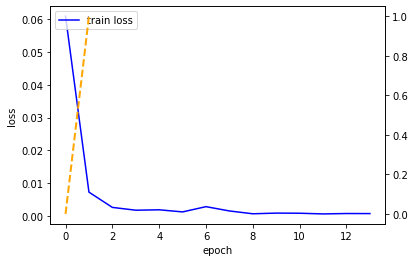

acc: 0.9999	loss: 0.0008
==========================================Result finished===========================================


In [24]:
import glob
import os
import numpy as np
import cv2
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from sklearn.metrics import roc_curve, confusion_matrix
from sklearn.utils import class_weight

%matplotlib inline
SEED = 777

def main():
    inputSize = 224
    batchSize = 16
    
    nEpoch = 14
    
    # 디렉토리 정보 설정
    # dataDir = 'D:\\Face_Database\\B-Database'
    dataDir = 'C:\\Users\\prlab\\Desktop\\bjy\\crop_result\\MSU-MFSD\\train'   
    # 학습 및 테스트 할 데이터베이스 디렉토리명
    trainDB = 'Result'  # D:\Face_Database\B-Database\protocol_4\train
    
    saveDir = 'trained_model_Result\\MSU-MFSD\\01'
    if not os.path.exists(saveDir):    
        os.makedirs(saveDir)
    model_path = os.path.join(saveDir, trainDB + '-{epoch:02d}-{loss:.4f}.hdf5')
    
    # 데이터베이스별 학습 수행
    print('>> ', trainDB)
    np.random.seed(SEED)

    print('ResNet-18'.center(100, '='))
    
    '''
    training
    '''
    K.clear_session()

    # 네트워크 정의
    model = ResNet18(input_shape=(inputSize, inputSize, 3), weights=None, include_top=False)

    # 데이터 generator 생성
    train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                       horizontal_flip=True,)
    train_generator = train_datagen.flow_from_directory(os.path.join(*[dataDir, trainDB, 'train']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=True,)


    # unbalanced class를 해결하기 위한 class_weight 설정
    class_weights = class_weight.compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes)

    # callback 함수 정의
    early_stop = EarlyStopping(patience=10, monitor='loss')
    cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='loss', verbose=1, save_best_only=True)

    # 모델 학습
    hist = model.fit_generator(train_generator, 
                               epochs=nEpoch,
                               steps_per_epoch=len(train_generator),
                               class_weight=class_weights,
                               verbose=1,
                               callbacks=[cb_checkpoint])

    
    # 학습 결과 그래프 그리기
    import matplotlib.pyplot as plt

    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    lw = 2
    
    plt.plot([0, 1], [0, 1], color='orange', lw=lw, linestyle='--')
    loss_ax.plot(hist.history['loss'], 'b', label='train loss')
#    loss_ax.plot(hist.history['val_loss'], '--r', label='val loss')
    
#    np.save('trained_model_Result\\MSU-MFSD\\MSU-MFSD-1', hist.history['loss'])
    
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')

    plt.show()
    print('acc: {:.4f}\tloss: {:.4f}'.format(hist.history['acc'][13], hist.history['loss'][13]))
    
    print(('{} finished'.format(trainDB)).center(100,'='))

        
if __name__ == '__main__':
    main()

# NUAA-PI

>>  Result
=============================================ResNet-18==============================================
Found 2980 images belonging to 2 classes.
Epoch 1/20
187/187 [==============================] - 15s 79ms/step - loss: 0.1306 - acc: 0.9672

Epoch 00001: loss improved from inf to 0.13101, saving model to trained_model_Result\NUAA-PI\01\Result-01-0.1310.hdf5
Epoch 2/20
187/187 [==============================] - 13s 69ms/step - loss: 0.0464 - acc: 0.9876

Epoch 00002: loss improved from 0.13101 to 0.04661, saving model to trained_model_Result\NUAA-PI\01\Result-02-0.0466.hdf5
Epoch 3/20
187/187 [==============================] - 13s 69ms/step - loss: 0.0382 - acc: 0.9880

Epoch 00003: loss improved from 0.04661 to 0.03698, saving model to trained_model_Result\NUAA-PI\01\Result-03-0.0370.hdf5
Epoch 4/20
187/187 [==============================] - 13s 70ms/step - loss: 0.0217 - acc: 0.9957

Epoch 00004: loss improved from 0.03698 to 0.02175, saving model to trained_model_Result\NUA

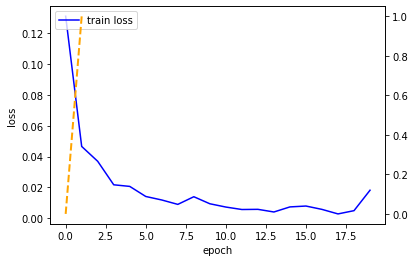

acc: 0.9953	loss: 0.0182
==========================================Result finished===========================================


In [25]:
import glob
import os
import numpy as np
import cv2
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from sklearn.metrics import roc_curve, confusion_matrix
from sklearn.utils import class_weight

%matplotlib inline
SEED = 777

def main():
    inputSize = 224
    batchSize = 16
    
    nEpoch = 20
    
    # 디렉토리 정보 설정
    # dataDir = 'D:\\Face_Database\\B-Database'
    dataDir = 'C:\\Users\\prlab\\Desktop\\bjy\\crop_result\\NUAA-PI\\train'   
    # 학습 및 테스트 할 데이터베이스 디렉토리명
    trainDB = 'Result'  # D:\Face_Database\B-Database\protocol_4\train
    
    saveDir = 'trained_model_Result\\NUAA-PI\\01'
    if not os.path.exists(saveDir):    
        os.makedirs(saveDir)
    model_path = os.path.join(saveDir, trainDB + '-{epoch:02d}-{loss:.4f}.hdf5')
    
    # 데이터베이스별 학습 수행
    print('>> ', trainDB)
    np.random.seed(SEED)

    print('ResNet-18'.center(100, '='))
    
    '''
    training
    '''
    K.clear_session()

    # 네트워크 정의
    model = ResNet18(input_shape=(inputSize, inputSize, 3), weights=None, include_top=False)

    # 데이터 generator 생성
    train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                       horizontal_flip=True,)
    train_generator = train_datagen.flow_from_directory(os.path.join(*[dataDir, trainDB, 'train']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=True,)


    # unbalanced class를 해결하기 위한 class_weight 설정
    class_weights = class_weight.compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes)

    # callback 함수 정의
    early_stop = EarlyStopping(patience=10, monitor='loss')
    cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='loss', verbose=1, save_best_only=True)

    # 모델 학습
    hist = model.fit_generator(train_generator, 
                               epochs=nEpoch,
                               steps_per_epoch=len(train_generator),
                               class_weight=class_weights,
                               verbose=1,
                               callbacks=[cb_checkpoint])

    
    # 학습 결과 그래프 그리기
    import matplotlib.pyplot as plt

    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    lw = 2
    
    plt.plot([0, 1], [0, 1], color='orange', lw=lw, linestyle='--')
    loss_ax.plot(hist.history['loss'], 'b', label='train loss')
#    loss_ax.plot(hist.history['val_loss'], '--r', label='val loss')
    
#    np.save('trained_model_Result\\NUAA-PI\\NUAA-PI-1', hist.history['loss'])
    
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')

    plt.show()
    print('acc: {:.4f}\tloss: {:.4f}'.format(hist.history['acc'][19], hist.history['loss'][19]))
    
    print(('{} finished'.format(trainDB)).center(100,'='))

        
if __name__ == '__main__':
    main()